# Ezana
# MSDS462 Module 1: Fashion MNIST Classification  
Objective: Build a Fashion classification model based 
on the Kaggle Fashion MNIST Data Set 

#Import and load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping


import time
from sklearn import metrics
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, UpSampling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, regularizers
from sklearn import metrics
from keras.optimizers import Adam, SGD
from keras.models import Model, load_model

print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [2]:
#Mount the drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/My Drive/ColabNotebooks/MSDS462/Module1/"

FashionMNIST_Module1_MSDS462.ipynb  t10k-labels-idx1-ubyte
fashion-mnist_test.csv		    train-images-idx3-ubyte
fashion-mnist_train.csv		    train-labels-idx1-ubyte
t10k-images-idx3-ubyte


In [4]:
train_df = pd.read_csv("/content/drive/My Drive/ColabNotebooks/MSDS462/Module1/fashion-mnist_train.csv")
test_df = pd.read_csv("/content/drive/My Drive/ColabNotebooks/MSDS462/Module1/fashion-mnist_test.csv")

In [5]:
# Shape of training nad test data
print(f'Shape of train_images: {train_df.shape}')
print(f'Shape of test_images: {test_df.shape}')

Shape of train_images: (60000, 785)
Shape of test_images: (10000, 785)


### Split Training Data into train and validate
* Split the training data into train and validate  
* Split out X and y from each dataset 
* format needed for model

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [6]:
train_data = np.array(train_df, dtype = 'float32')
test_data = np.array(test_df, dtype='float32')

#The pixel values for the images lie between 0 to 255 now, which is a large range.
#Let us normalize these values to a range from 0 to 1. To do this, we can simply divide each pixel value with 255

X_train = train_data[:,1:]/255

y_train = tf.keras.utils.to_categorical(train_data[:,0])  # this is our target, thats why we are not dividing it

X_test= test_data[:,1:]/255

y_test= tf.keras.utils.to_categorical(test_data[:,0])      #this is our target, thats why we are not dividing it

In [7]:
image_rows, image_cols = 28, 28
image_shape = (image_rows, image_cols ,1)

In [8]:
# test_size means 20 % data will be considered for testing the model
# random state is just for freezing .i.e we can take any number
X_train,X_validate,y_train,y_validate = train_test_split(X_train,y_train,test_size = 0.2,random_state = 45)

X_train = X_train.reshape(X_train.shape[0],*image_shape)
X_test = X_test.reshape(X_test.shape[0],*image_shape)
X_validate = X_validate.reshape(X_validate.shape[0],*image_shape)

In [9]:
# Check the shape of the y values
print(X_train.shape)
print(X_test.shape)
print(X_validate.shape)

(48000, 28, 28, 1)
(10000, 28, 28, 1)
(12000, 28, 28, 1)


In [10]:
# Check the shape of the y values
print(y_train.shape)
print(y_test.shape)
print(y_validate.shape)

(48000, 10)
(10000, 10)
(12000, 10)


#Examine the dataset after reshaping to a 28 * 28 vector with single channel
(28,28,1)

In [32]:
labelNames = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [11]:
def plot_accuracy(history):
    plt.figure()
    plt.plot(range(len(history.history["accuracy"])), history.history["accuracy"], "bo", label="Training Accuracy")
    plt.plot(range(len(history.history["accuracy"])), history.history["val_accuracy"], "g", label="Validation Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.figure()
    plt.plot(range(len(history.history["accuracy"])), history.history["loss"], "bo", label="Training Loss")
    plt.plot(range(len(history.history["accuracy"])), history.history["val_loss"], "g", label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    plt.show()

In [28]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
def plot_data_samples(data, rows, columns):
   fig,ax = plt.subplots(rows,columns,figsize = (16,16))
   ax = ax.ravel()
   for i in range(0, rows * columns):
        ax[i].imshow(data[i].reshape(28,28),cmap=plt.cm.binary)  

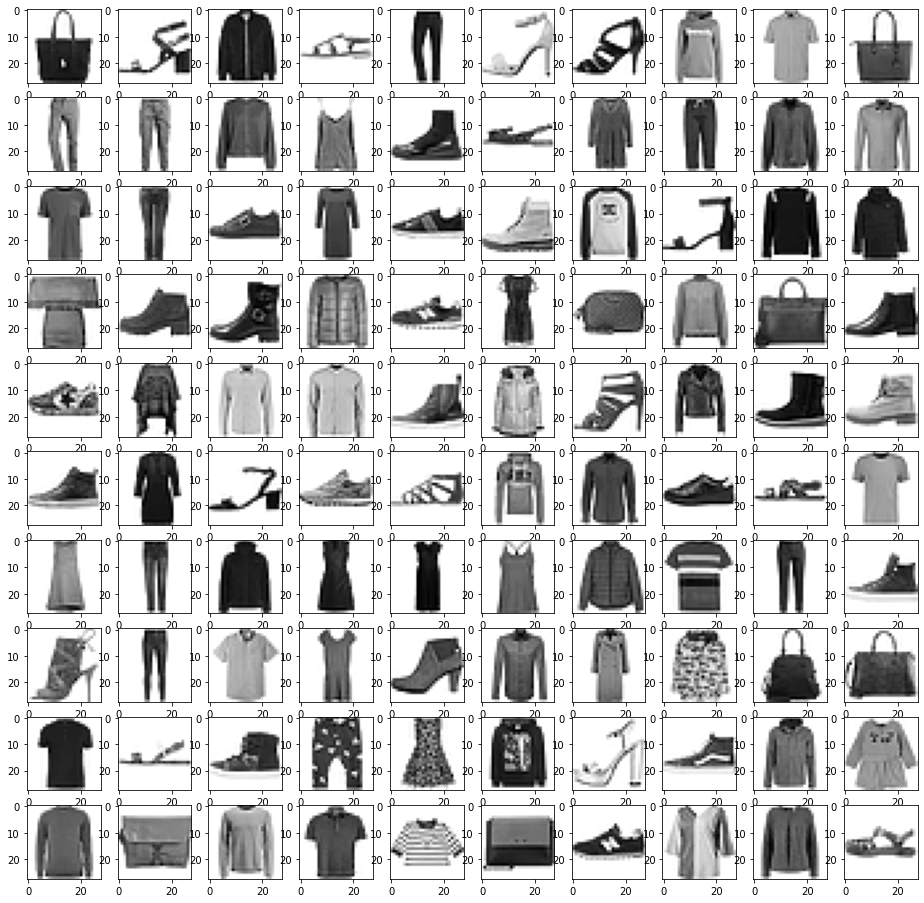

In [13]:
#Sample the X training data
plot_data_samples(X_train, 10, 10)

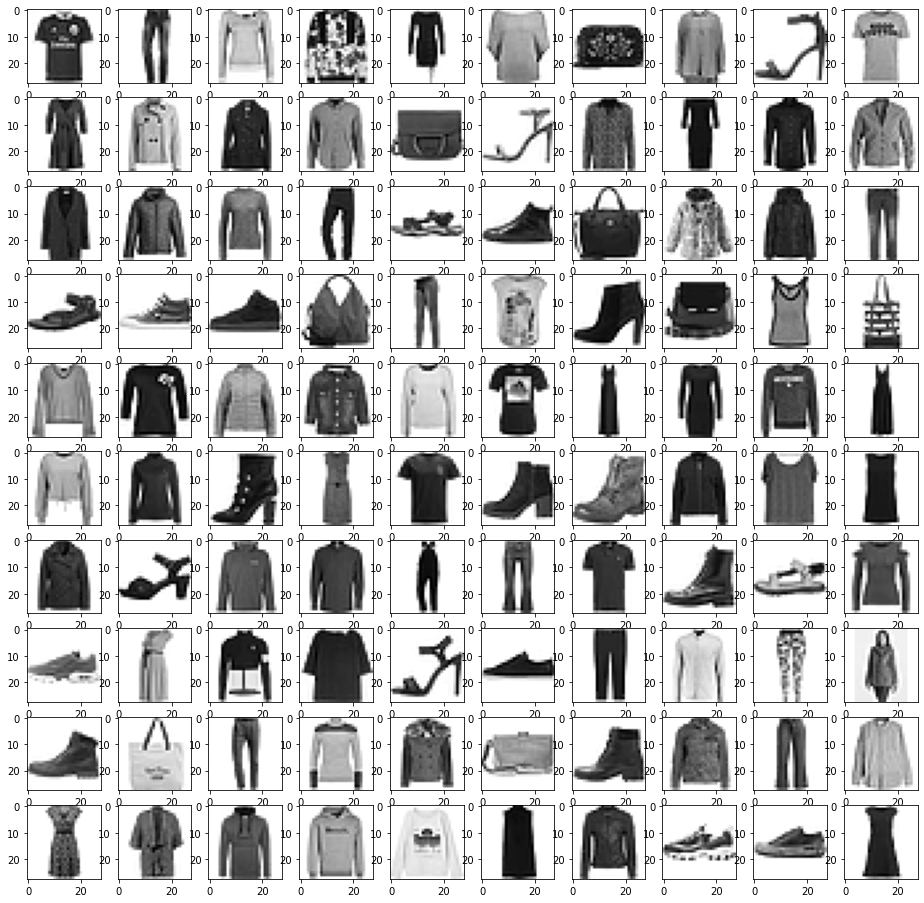

In [14]:
#Sample the X test data
plot_data_samples(X_test, 10, 10)

In [15]:
# Check the traning label, have 10 classes with 6000 images
train_df['label'].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>


## Setup a 6 Convolutional Layers 
the model is setup with a categorical cross entropy loss  and adamax optimizer and accuracy metric, with L2 regularization, dropout, batch normalization
and early stopping

In [21]:
checkpointer = ModelCheckpoint(filepath="save/cnn_mnist.hdf5", verbose=0, save_best_only=True) # save best model
input_shape = (28, 28, 1)
learning_rate = 0.001

#Build network
model = Sequential()

model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), input_shape=input_shape)) 
model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 96)        960       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 96)        83040     
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 96)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 96)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 128)       110720    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)        

In [22]:
start = time.time()

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size= 64,
    epochs=50,
    callbacks=[monitor,checkpointer],
    validation_data=(X_validate, y_validate),
    shuffle= True
)   

end = time.time()
cnn_mnist_time = end-start
print("Total training time Model 2 is {:0.2f} minute".format(cnn_mnist_time/60.0))

Epoch 1/50
750/750 [==============================] - 12s 14ms/step - loss: 1.9091 - accuracy: 0.6004 - val_loss: 1.0438 - val_accuracy: 0.7919
Epoch 2/50
750/750 [==============================] - 10s 13ms/step - loss: 0.9837 - accuracy: 0.8148 - val_loss: 0.7326 - val_accuracy: 0.8537
Epoch 3/50
750/750 [==============================] - 10s 13ms/step - loss: 0.7565 - accuracy: 0.8500 - val_loss: 0.6549 - val_accuracy: 0.8673
Epoch 4/50
750/750 [==============================] - 10s 13ms/step - loss: 0.6875 - accuracy: 0.8582 - val_loss: 0.5945 - val_accuracy: 0.8746
Epoch 5/50
750/750 [==============================] - 10s 13ms/step - loss: 0.6479 - accuracy: 0.8617 - val_loss: 0.6060 - val_accuracy: 0.8750
Epoch 6/50
750/750 [==============================] - 10s 13ms/step - loss: 0.6235 - accuracy: 0.8691 - val_loss: 0.6033 - val_accuracy: 0.8633
Epoch 7/50
750/750 [==============================] - 10s 13ms/step - loss: 0.6088 - accuracy: 0.8716 - val_loss: 0.5710 - val_accuracy:

In [23]:
model_score = model.evaluate(X_test, y_test)
# checking the test loss and test accuracy
print('Test loss:', model_score[0])
print('Test accuracy:', model_score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.4064 - accuracy: 0.9108
Test loss: 0.4063778221607208
Test accuracy: 0.9107999801635742


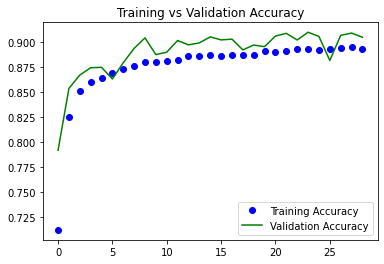

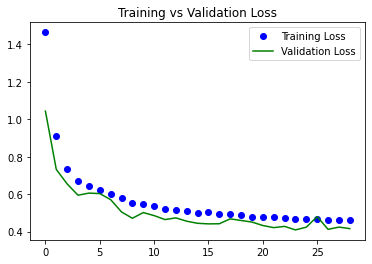

In [24]:
plot_accuracy(history)

In [25]:
#Load the model weights
model.load_weights("save/cnn_mnist.hdf5")

In [34]:
cnn_pred_mnist = model.predict(X_test)
cnn_pred_mnist = np.argmax(cnn_pred_mnist,axis=1)
y_true = np.argmax(y_test,axis=1)

cnn_f1_mnist = metrics.f1_score(y_true, cnn_pred_mnist, average= "weighted")
cnn_accuracy_mnist = metrics.accuracy_score(y_true, cnn_pred_mnist)
cnn_cm_mnist = metrics.confusion_matrix(y_true, cnn_pred_mnist)
print("-----------------Convolutional Neural Network Report---------------")
print("F1 score: {}".format(cnn_f1_mnist))
print("Accuracy score: {}".format(cnn_accuracy_mnist))


-----------------Convolutional Neural Network Report---------------
F1 score: 0.9125429703123312
Accuracy score: 0.9131


Plotting confusion matrix


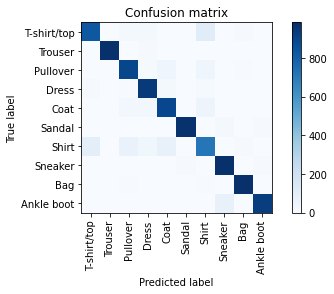

              precision    recall  f1-score   support

           0       0.88      0.83      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.88      0.90      0.89      1000
           3       0.89      0.95      0.92      1000
           4       0.86      0.89      0.88      1000
           5       0.99      0.97      0.98      1000
           6       0.76      0.71      0.74      1000
           7       0.92      0.98      0.95      1000
           8       0.97      0.98      0.98      1000
           9       0.98      0.93      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [35]:
#Show the confusion matrix for the 6 layer CNN
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cnn_cm_mnist, labelNames)
plt.show()


print(metrics.classification_report(y_true, cnn_pred_mnist))